### Подготовка

In [2]:
import numpy as np
import scipy
from scipy.stats import norm, multivariate_normal, expon, uniform

import seaborn as sns
from matplotlib import pyplot as plt

from tqdm.auto import tqdm

Перенесём ядерный метод восстановления плотности из прошлой лабораторной работы

In [3]:
def KDE(X, points, h, kernel='Гауссово ядро'):
    X = np.repeat(X[:, np.newaxis], points.shape[0], 1)
    u = (X - points) / h
    match kernel:
        case 'Равномерное ядро':
            S = np.mean((np.abs(u) <= 1).astype(float) / 2, axis=0)
        case 'Треугольное ядро':
            S = np.mean(1 - np.abs(np.clip(u, a_min=-1, a_max=1)), axis=0)
        case 'Ядро Епанечникова':
            S = 0.75 * np.mean(1 - np.square(np.clip(u, a_min=-1, a_max=1)), axis=0)
        case 'Биквадратное ядро':
            S = 0.9375 * np.mean(np.square(1 - np.square(np.clip(u, a_min=-1, a_max=1))), axis=0)
        case 'Гауссово ядро':
            S = np.mean(norm.pdf(u), axis=0)
    S /= h
    return S

Это вспомогательный класс с методом pdf, который возвращает значение функции плотности распределения

Он нужен для того, чтобы в метод Метрополиса-Гастингса подавать как объявленные в самой программе плотности распределения, так и плостности из пакета scipy.stats

In [4]:
class Distribution():
    def __init__(self, density):
        self.density = density

    def pdf(self, x):
        return self.density(x)

In [177]:
def change_param(q, x, unchangable_params):
    if isinstance(q, scipy.stats._continuous_distns.uniform_gen):
        return x - unchangable_params['scale'] / 2
    return x

Опеределим метод Метрополиса-Гастингса для семплирования точек из распределения

In [157]:
def metropolis_hastings(p, q, n_iter, borders, size, changable_param='', unchangable_params={}):
    x_t = np.random.uniform(*borders, size=size)
    points = np.array([x_t])
    if size == 1:
       x_t = x_t[0]
    for _ in tqdm(range(1, n_iter)):
        x_new = q.rvs()
        p_t, p_new = p.pdf(x_t), p.pdf(x_new)
        q_t = q(**{changable_param: change_param(q, x_new, unchangable_params)}, **unchangable_params).pdf(x_t)
        q_new = q(**{changable_param: change_param(q, x_t, unchangable_params)}, **unchangable_params).pdf(x_new)
        if np.isclose(p_t, 0) and np.isclose(q_new, 0):
            if np.isclose(p_new, 0) and np.isclose(q_t, 0): u = 1
            else: u = np.infty
        elif np.isclose(p_t, 0):
            if np.isclose(p_new, 0) and np.isclose(q_t, 0): u = 0
            elif np.isclose(p_new, 0): u = q_t / q_new
            elif np.isclose(q_t, 0): u = p_new / q_new
            else: u = np.infty
        elif np.isclose(q_new, 0):
            if np.isclose(p_new, 0) and np.isclose(q_t, 0): u = 0
            elif np.isclose(p_new, 0): u = q_t / p_t
            elif np.isclose(q_t, 0): u = p_new / p_t
            else: u = np.infty
        else:
            if np.isclose(p_new, 0) or np.isclose(q_t, 0): u = 0
            else: u = (p_new * q_t) / (p_t * q_new)
        if np.random.rand() < u:
            x_t = x_new
        if size == 1:
            points = np.append(points, x_t)
        else:
            points = np.concatenate((points, x_t[np.newaxis, :]))
    return points

In [139]:
def plot_densities(generated, borders, h, title, figsize=(12, 7), kernel='Гауссово ядро'):
    generated = np.sort(generated)
    points = np.linspace(*borders, generated.shape[0])
    fig, ax = plt.subplots(figsize=figsize)
    distribution_density, kde_density = distribution.pdf(points), KDE(generated, points, h, kernel=kernel)
    plt.plot(points, distribution_density, label='Истинная плотность')
    plt.plot(points, kde_density, label='Восстановленная плотность')
    plt.grid()
    plt.legend()
    plt.title(f'KL-дивергенция равняется {KL_divergency(distribution_density, kde_density)}')
    fig.suptitle(title)
    plt.show()

Определим функцию для подсчёта KL-дивергенции между истинным распределением и восстановленным с помощью ядерного метода из прошлой лабораторной работы

In [147]:
def KL_divergency(p, q, epsilon=1e-15):
    assert p.shape[0] == q.shape[0], 'p and q must have equal dimensions'
    p, q = p / np.sum(p), q / np.sum(q)
    return np.sum(p * np.log((p + epsilon) / (q + epsilon)))

### Аппроксимация нормальным распределением

Начнём с нормального распределения

  0%|          | 0/10000 [00:00<?, ?it/s]

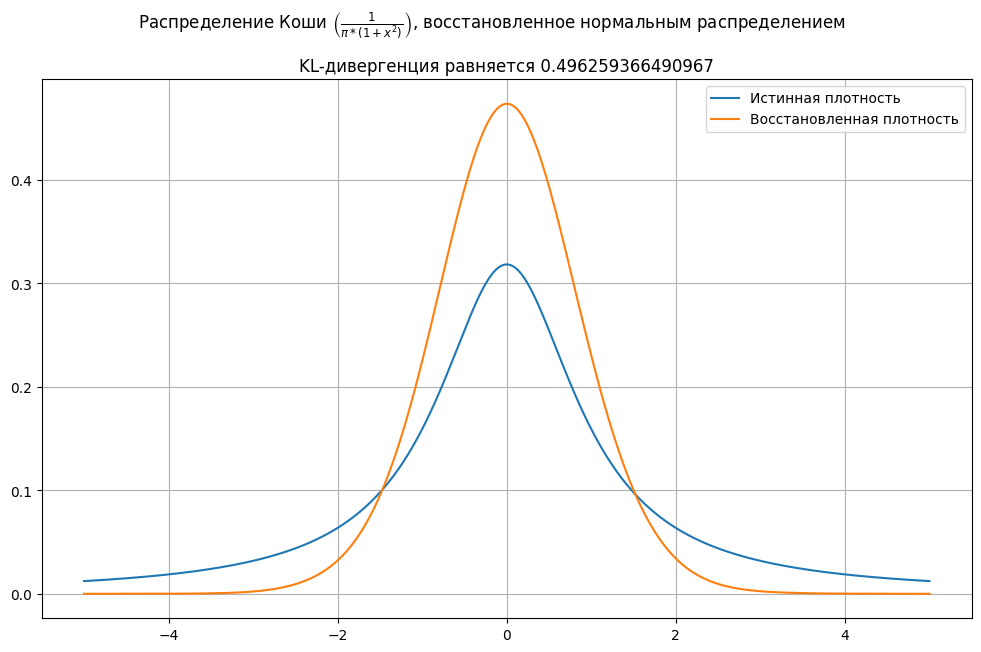

In [168]:
distribution = Distribution(lambda x: 1 / (np.pi * (1 + np.square(x))))
generated = metropolis_hastings(distribution, norm, 10000, [-3, 3], 1, changable_param='loc', unchangable_params={'scale': 1})
plot_densities(generated, [-5, 5], 0.5, f'Распределение Коши $\\left(\\frac{{1}}{{\pi * \\left(1 + x^2\\right)}}\\right)$, восстановленное нормальным распределением')

  0%|          | 0/10000 [00:00<?, ?it/s]

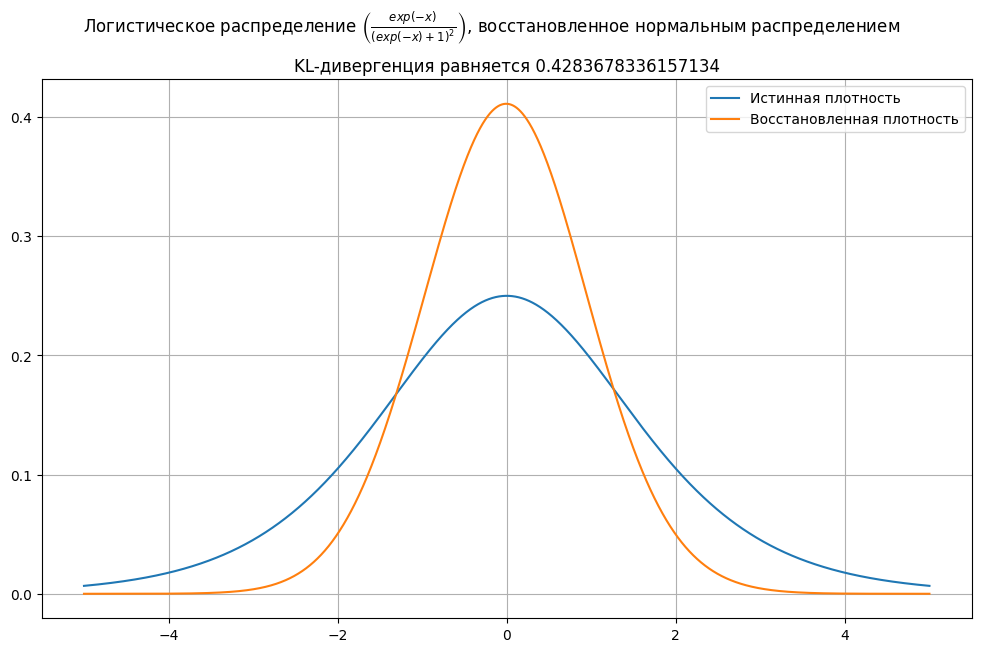

In [169]:
distribution = Distribution(lambda x: np.exp(-x) / np.square(np.exp(-x) + 1))
generated = metropolis_hastings(distribution, norm, 10000, [-3, 3], 1, changable_param='loc', unchangable_params={'scale': 1})
plot_densities(generated, [-5, 5], 0.5, f'Логистическое распределение $\\left(\\frac{{exp\\left(-x\\right)}}{{\\left(exp\\left(-x\\right) + 1\\right)^2}}\\right)$, восстановленное нормальным распределением')

  0%|          | 0/10000 [00:00<?, ?it/s]

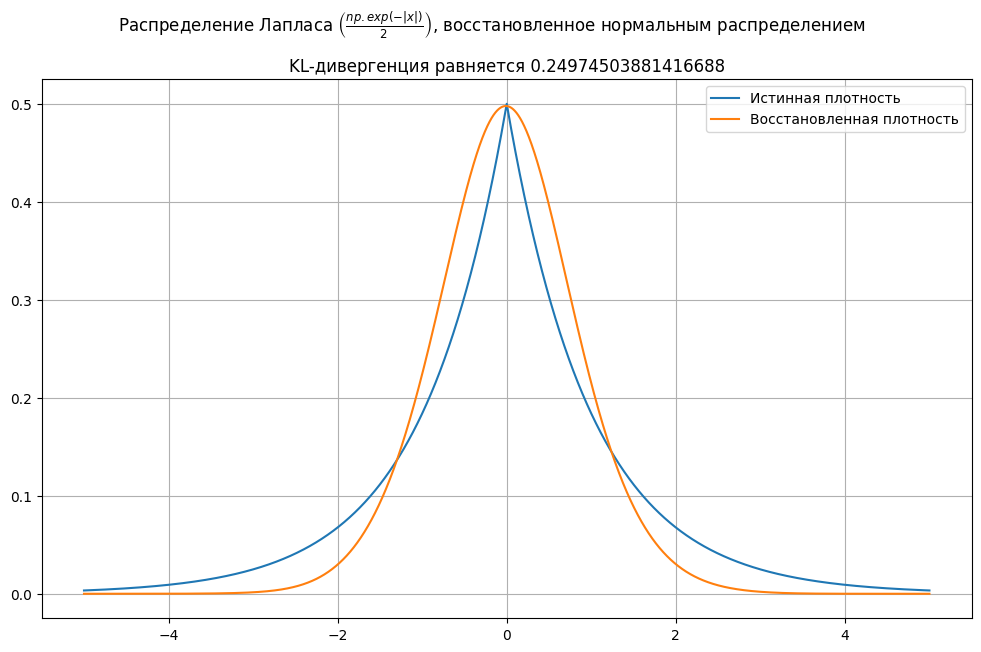

In [170]:
distribution = Distribution(lambda x: np.exp(-np.abs(x)) / 2)
generated = metropolis_hastings(distribution, norm, 10000, [-3, 3], 1, changable_param='loc', unchangable_params={'scale': 1})
plot_densities(generated, [-5, 5], 0.5, f'Распределение Лапласа $\\left(\\frac{{np.exp\\left(-|x|\\right)}}{{2}}\\right)$, восстановленное нормальным распределением')

**Вывод**: нормальное распределение весьма неплохо аппроксимирует плотность по точкам, хотя "купола" полученных плотностей выше "купола" истинного, а хвосты - наоборот, ниже

### Аппроксимация равномерным распределением

  0%|          | 0/10000 [00:00<?, ?it/s]

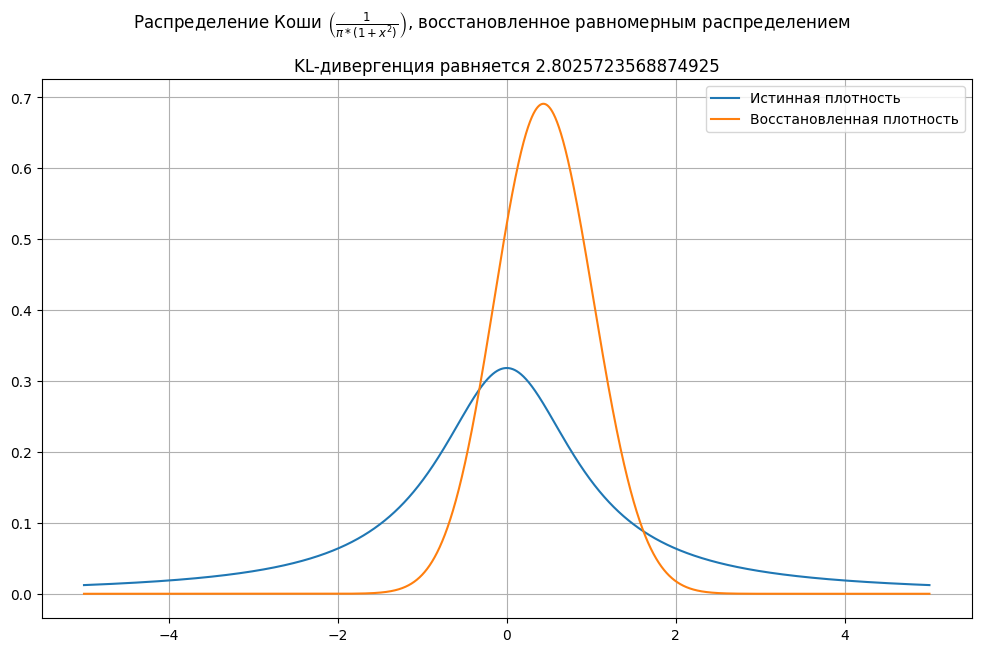

In [179]:
distribution = Distribution(lambda x: 1 / (np.pi * (1 + np.square(x))))
generated = metropolis_hastings(distribution, uniform, 10000, [-3, 3], 1, changable_param='loc', unchangable_params={'scale': 6})
plot_densities(generated, [-5, 5], 0.5, f'Распределение Коши $\\left(\\frac{{1}}{{\pi * \\left(1 + x^2\\right)}}\\right)$, восстановленное равномерным распределением')

  0%|          | 0/10000 [00:00<?, ?it/s]

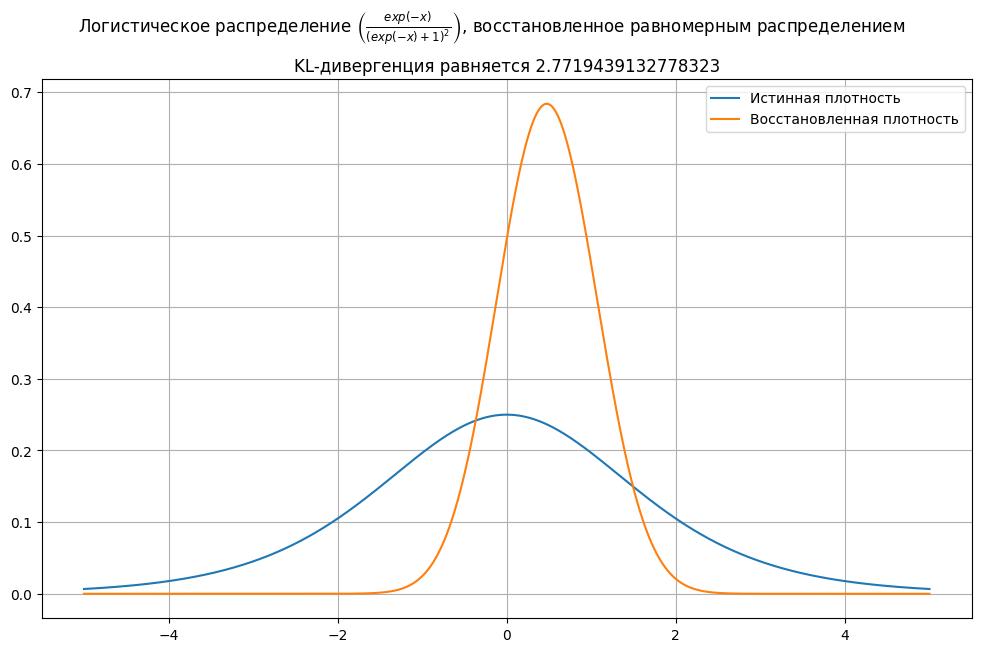

In [180]:
distribution = Distribution(lambda x: np.exp(-x) / np.square(np.exp(-x) + 1))
generated = metropolis_hastings(distribution, uniform, 10000, [-3, 3], 1, changable_param='loc', unchangable_params={'scale': 6})
plot_densities(generated, [-5, 5], 0.5, f'Логистическое распределение $\\left(\\frac{{exp\\left(-x\\right)}}{{\\left(exp\\left(-x\\right) + 1\\right)^2}}\\right)$, восстановленное равномерным распределением')

  0%|          | 0/10000 [00:00<?, ?it/s]

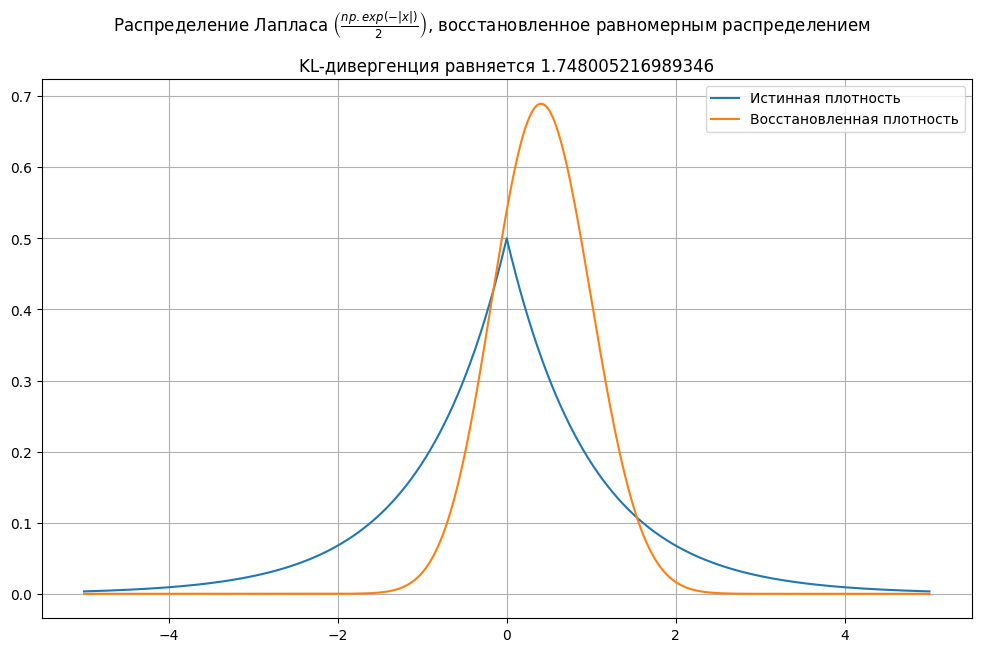

In [181]:
distribution = Distribution(lambda x: np.exp(-np.abs(x)) / 2)
generated = metropolis_hastings(distribution, uniform, 10000, [-3, 3], 1, changable_param='loc', unchangable_params={'scale': 6})
plot_densities(generated, [-5, 5], 0.5, f'Распределение Лапласа $\\left(\\frac{{np.exp\\left(-|x|\\right)}}{{2}}\\right)$, восстановленное равномерным распределением')

**Вывод**: что ж, равномерное распределение справилось куда хуже нормального, KL-дивергенция для каждого из тестовых распределений подросла в несколько раз

### Аппроксимация экспоненциальным распределением

Экспоненциальное распределение является асимметричным, тут и нужна будет поправка на ассиметрию в методе Метрополиса-Гастингса

Здесь аппроксимироваться будет только положительная часть каждого распределения, так как если этого не делать, то метод Метрополиса-Гастингса будет генерировать около 10 различных значений вместо обычных 6000-7000 из общего количества в 10000

  0%|          | 0/10000 [00:00<?, ?it/s]

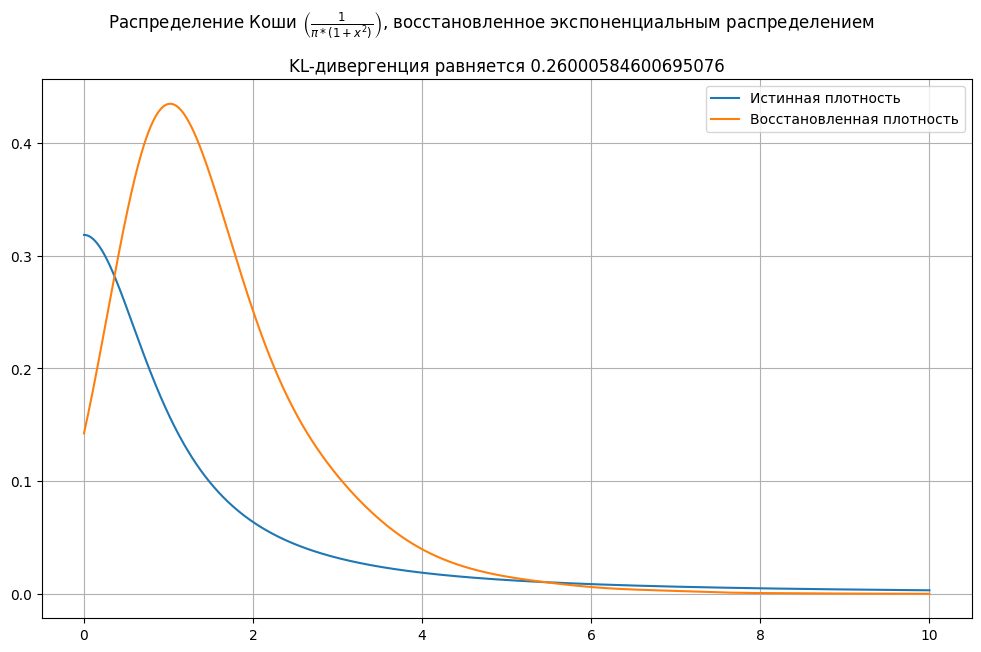

In [163]:
distribution = Distribution(lambda x: 1 / (np.pi * (1 + np.square(x))))
generated = metropolis_hastings(distribution, expon, 10000, [0, 3], 1, changable_param='scale')
plot_densities(generated, [0, 10], 0.5, f'Распределение Коши $\\left(\\frac{{1}}{{\pi * \\left(1 + x^2\\right)}}\\right)$, восстановленное экспоненциальным распределением')

  0%|          | 0/10000 [00:00<?, ?it/s]

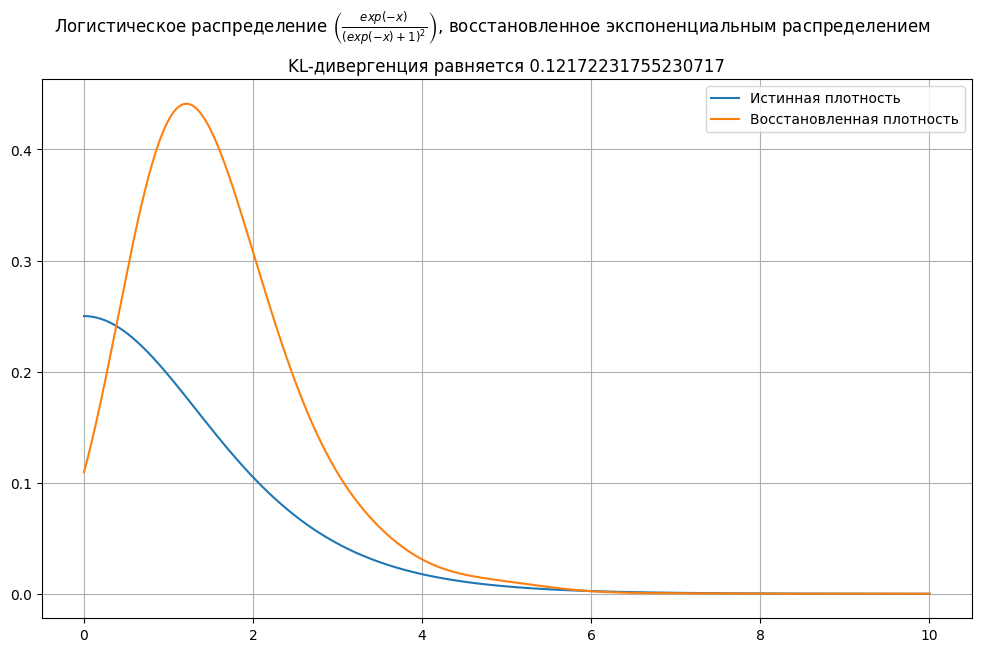

In [166]:
distribution = Distribution(lambda x: np.exp(-x) / np.square(np.exp(-x) + 1))
generated = metropolis_hastings(distribution, expon, 10000, [0, 3], 1, changable_param='scale')
plot_densities(generated, [0, 10], 0.5, f'Логистическое распределение $\\left(\\frac{{exp\\left(-x\\right)}}{{\\left(exp\\left(-x\\right) + 1\\right)^2}}\\right)$, восстановленное экспоненциальным распределением')

  0%|          | 0/10000 [00:00<?, ?it/s]

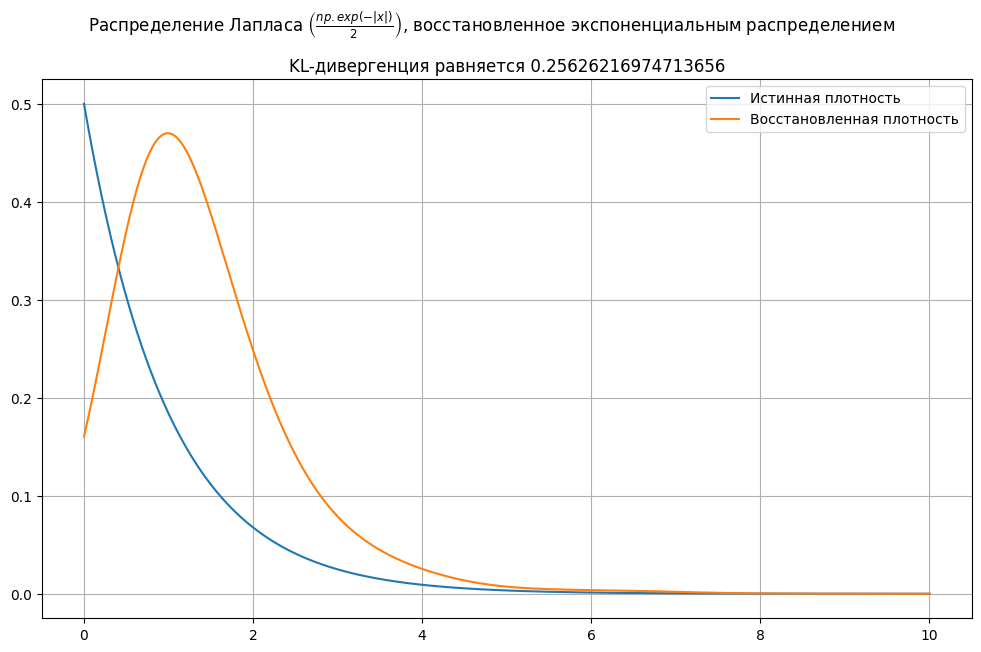

In [167]:
distribution = Distribution(lambda x: np.exp(-np.abs(x)) / 2)
generated = metropolis_hastings(distribution, expon, 10000, [0, 3], 1, changable_param='scale')
plot_densities(generated, [0, 10], 0.5, f'Распределение Лапласа $\\left(\\frac{{np.exp\\left(-|x|\\right)}}{{2}}\\right)$, восстановленное экспоненциальным распределением')

**Вывод**: у экспоненциального распределения всегда получается этот купол, так как в окрестности нуля не может быть бесконечно большого числа точек. KL-дивергенция при этом не очень большая

### Выводы

В данной лабораторнойработе я ревлизовал метод Метрополиса-Гастингса для сэмплирования точек из одномерного распределения

В качестве вспомогательных распределений выступали нормальное, равномерное и экспорненциальное, а в качестве тестовых - логистическое, распределние Коши, распределение Лапласа. Лучшие результаты продемонстрировало нормаьное распределение в качестве тестового, KL-дивергенция там была наименьшей